# Prepare the Data

## Libraries Imports

In [221]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score

## Load the Data

In [222]:
names =[
    'index',
    'location', 'country',                                                  # the country and location of the person
    'gender', 'age',                                                        # gender and age of the person
    'vis_wuhan', 'from_wuhan',                                              # whether the person visited wuhan or from wuhan
    'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6', # symptoms appeared on the person
    'diff_sym_hos',                                                         # time before symptoms appear
    'result'                                                                # death or recovered
]
df = pd.read_csv("data.csv", names = names)
df.drop(index = 0, axis = 1, inplace = True)

In [223]:
df.head(6)

,index,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
1,0.0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
2,1.0,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
3,2.0,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
4,3.0,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
5,4.0,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0
6,5.0,23,8,0,44.0,0,1,14,31,19,12,3,1,0,0


## Visualize the Data

<Axes: xlabel='result'>

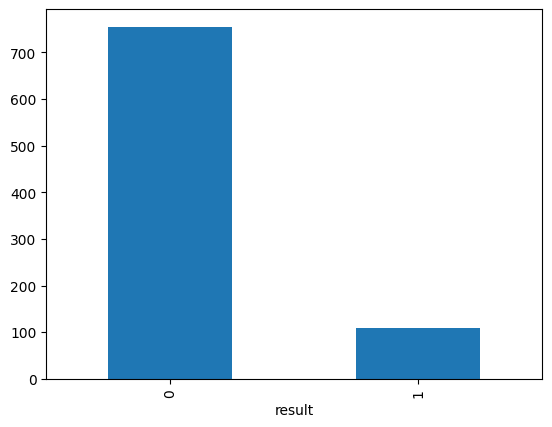

In [224]:
df["result"].value_counts().plot(kind="bar")

## Split the Data

In [225]:
X_data = df[['location', 'country', 'gender', 'age', 'vis_wuhan', 'from_wuhan', 'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6', 'diff_sym_hos']].astype('float')
y_data = df['result'].astype('int')

X_train = X_data.iloc[:517,:]
y_train = y_data.iloc[:517]
X_validate = X_data.iloc[517:690,:]
y_validate = y_data.iloc[517:690]
X_test = X_data.iloc[690:,:]
y_test = y_data.iloc[690:]

## Useful Functions

In [226]:
def get_metrics(y, y_pred, y_prob):
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y_validate, y_prob)

    metrics_table = pd.DataFrame({
        "metric": ["Precision", "Recall", "F1", "ROC AUC"],
        "values": [precision, recall, f1, roc_auc]
    })
    metrics_table["values"] *= 100

    return metrics_table

In [227]:
def draw_roc(y, y_prob):
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    plt.plot(fpr, tpr, color='blue', label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='random classifier')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# K Nearest Neighbors

## Train the Model

In [228]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


KNeighborsClassifier(metric='euclidean', n_neighbors=6, weights='distance')

## Validate the Model

### First Trail

In [229]:
# Calculate the predicted result
y_pred_validate = best_knn.predict(X_validate)
y_prob_validate = best_knn.predict_proba(X_validate)[:, 1]

In [230]:
# Compute test metrics
get_metrics(y_validate, y_pred_validate, y_prob_validate)

,metric,values
0,Precision,66.666667
1,Recall,19.047619
2,F1,29.629630
3,ROC AUC,76.284461


In [231]:
best_knn.score(X_validate, y_validate)

0.8901734104046243

### Second Trail

## Test the Model

In [232]:
# Calculate the predicted result
y_pred_test = best_knn.predict(X_test)
y_prob_test = best_knn.predict_proba(X_test)[:, 1]

In [233]:
# Compute test metrics
get_metrics(y_test, y_pred_test, y_prob_test)

,metric,values
0,Precision,100.000000
1,Recall,48.275862
2,F1,65.116279
3,ROC AUC,54.589599


<Axes: >

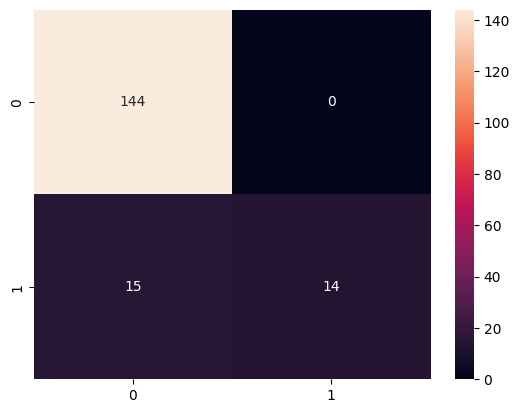

In [234]:
# Compute the confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix_test, annot=True, fmt='.0f')

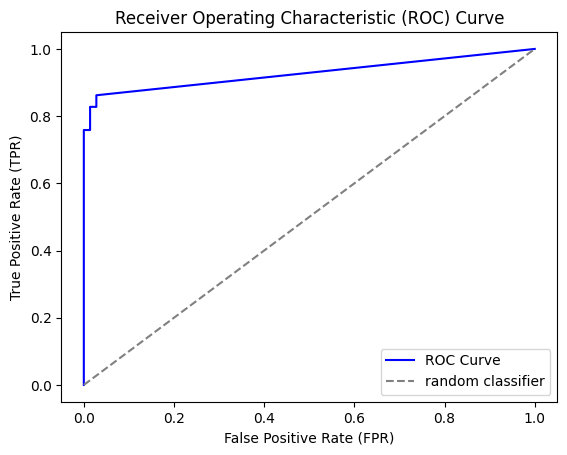

In [235]:
draw_roc(y_test, y_prob_test)

# Logistic Regression

## Train the Model

In [236]:
from sklearn import linear_model, preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)

regr = linear_model.LogisticRegression()
regr.fit(X_train_minmax, y_train)

LogisticRegression()

## Validate the Model

### First Trail

In [237]:
# Calculate the predicted result
X_validate_minmax = min_max_scaler.fit_transform(X_validate)

y_validate_pred = regr.predict(X_validate_minmax)
y_validate_prob = regr.predict_proba(X_validate_minmax)[:, 1]

In [238]:
# Compute test metrics
get_metrics(y_validate, y_validate_pred, y_validate_prob)

,metric,values
0,Precision,100.000000
1,Recall,9.523810
2,F1,17.391304
3,ROC AUC,83.176692


In [239]:
regr.score(X_validate_minmax, y_validate)

0.8901734104046243

### Second Trail

In [240]:
regr.class_weight = 'balanced'
regr.fit(X_train_minmax, y_train)

y_validate_pred = regr.predict(X_validate_minmax)
y_validate_prob = regr.predict_proba(X_validate_minmax)[:, 1]

In [241]:
# Compute test metrics
get_metrics(y_validate, y_validate_pred, y_validate_prob)

,metric,values
0,Precision,81.250000
1,Recall,61.904762
2,F1,70.270270
3,ROC AUC,83.020050


In [242]:
regr.score(X_validate_minmax, y_validate)

0.9364161849710982

## Test the Model

In [243]:
# Calculate the predicted result
X_test_minmax = min_max_scaler.fit_transform(X_test)

y_test_pred = regr.predict(X_test_minmax)
y_test_prob = regr.predict_proba(X_test_minmax)[:, 1]

In [244]:
# Compute test metrics
get_metrics(y_test, y_test_pred, y_test_prob)

,metric,values
0,Precision,100.000000
1,Recall,20.689655
2,F1,34.285714
3,ROC AUC,53.023183


<Axes: >

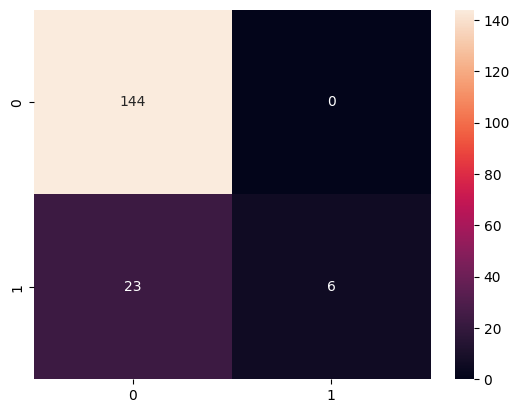

In [245]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='.0f')

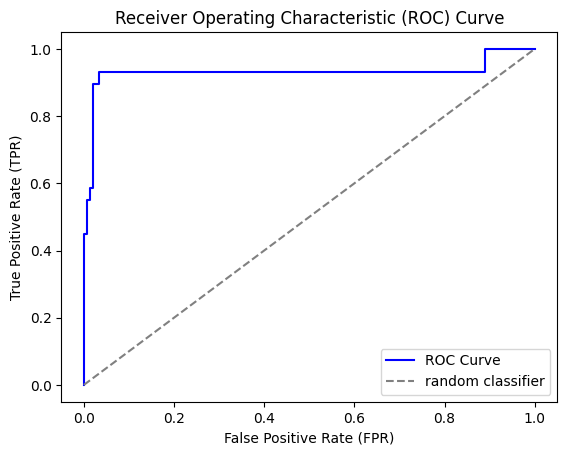

In [246]:
draw_roc(y_test, y_test_prob)

# Descision Trees

## Train the Model

## Validate the Model

## Test the Model